## Water mass transformation
### 3 stages of calculation
* Get tracer tendency (involves calculation of, for example, density tendency from heat and salt tendencies)
    * Also here specify "prefactors" in watermass transformation calculation, such as density, b-factor, or tracer concentration
* Vertical coordinate transformation to tracer layers
* Integrate within layers to get water mass transformation

#### Things that need improvement/better understanding
* Conversion of heat and salt tendency to density tendency
* Coordinate transformation options - how to wrap functions into wmt calculation
* When calculating watermass transformation due to several terms (e.g. different heat tendency terms), it may be more efficient to do the coordinate transformation first (i.e. not each time I specify ldot). This will likely depend on the transformation approach itself.  

* Complementary function(s) to integrate quantities for all space greater than (or less than) specific tracer contour, e.g. volume, or mass or  tendencies
    * Here, the coordinate transformation can be the same, it is just the integration stage that is different (which involves a cumulative sum, rather than a sum within each layer)

In [25]:
# Import packages
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
from matplotlib import pyplot as plt

In [26]:
# Load data
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/5d/'
filename = '19000101.ocean_daily.nc'
ds = xr.open_dataset(rootdir+filename)
filename_grid = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+filename_grid)
cp = 3992.0
rho0 = 1035.0

#### Wrap watermass transformation calculation into a function

In [27]:
def calc_watermasstransformation(tracer,tracer_tendency,tracer_contour_values,prefactor,area,coordinate_transform_method=None,extensive_tendency=True,**kwargs):
    l = tracer.copy()
    ldot = tracer_tendency.copy()
    l_i_vals = tracer_contour_values.copy()
    
    # Specify pre-factors to ldot, e.g. density, b-factor, or tracer concentration
    ldotnew = prefactor*ldot
    
    # Transform vertical coordinate to layers of tracer, which we call l
    if coordinate_transform_method=='xhistogram':
        ldotnew_l = histogram(l,bins=[l_i_vals],dim=['zl'],weights=ldotnew)
    
    # Calculate water mass transformatin: integrate tendency (with pre-factors) within layers of l, and divide by delta_l
    delta_l_i = np.diff(l_i_vals)
    if extensive_tendency:
        wmt = (ldotnew_l*area).sum(['xh','yh'])/delta_l_i
    else:
        wmt = (ldotnew_l*area*thickness).sum(['xh','yh'])/delta_l_i
    
    return wmt

#### Example: temperature, boundary forcing
Specify function arguments

In [28]:
# TRACER
l = ds['temp']
# TRACER TENDENCY
ldot = ds['boundary_forcing_heat_tendency']/cp/rho0
# PREFACTOR
prefactor = rho0
# TRACER CONTOUR VALUES
l_i_vals = np.arange(-4,34,0.25)
# GRID DETAILS
area = grid['areacello']

Calculate water mass transformation

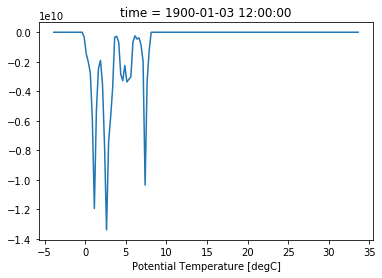

In [29]:
wmt = calc_watermasstransformation(tracer = l,
                                   tracer_tendency = ldot,
                                   tracer_contour_values = l_i_vals,
                                   prefactor = rho0,
                                   area = area,
                                   coordinate_transform_method='xhistogram',
                                   extensive_tendency=True)
wmt.isel(time=0).plot()

#### Example: temperature, sum of all forcing
Specify function arguments

In [30]:
# TRACER
l = ds['temp']
# TRACER TENDENCY
tendency_terms = ['boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
ldot = xr.zeros_like(ds[tendency_terms[0]])
for term in tendency_terms:
    ldot += ds[term]/cp/rho0
# PREFACTOR
prefactor = rho0
# TRACER CONTOUR VALUES
l_i_vals = np.arange(-4,34,0.25)
# GRID DETAILS
area = grid['areacello']

Calculate water mass transformation

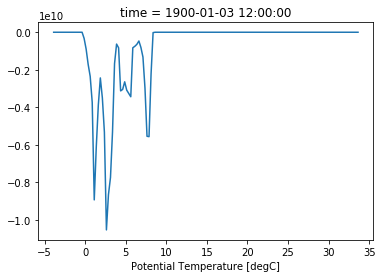

In [31]:
wmt = calc_watermasstransformation(tracer = l,
                                   tracer_tendency = ldot,
                                   tracer_contour_values = l_i_vals,
                                   prefactor = rho0,
                                   area = area,
                                   coordinate_transform_method='xhistogram',
                                   extensive_tendency=True)
wmt.isel(time=0).plot()

#### Example: temperature, all forcings
Specify function arguments

In [32]:
# TRACER
l = ds['temp']
# TRACER TENDENCY
tendency_terms = ['boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
# PREFACTOR
prefactor = rho0
# TRACER CONTOUR VALUES
l_i_vals = np.arange(-4,34,0.25)
# GRID DETAILS
area = grid['areacello']

Calculate water mass transformation

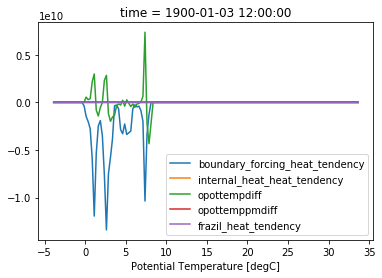

In [34]:
wmt = {}
for term in tendency_terms:
    ldot = ds[term]/cp/rho0
    wmt[term] = calc_watermasstransformation(tracer = l,
                                   tracer_tendency = ldot,
                                   tracer_contour_values = l_i_vals,
                                   prefactor = prefactor,
                                   area = area,
                                   coordinate_transform_method='xhistogram',
                                   extensive_tendency=True)
    wmt[term].isel(time=0).plot(label=term)
plt.legend()

#### Example: density, all forcing

First, calculate the tendency in density from tendencies of heat and salt

In [35]:
def calc_densitytendency(salttendency,heattendency,salinity,drho_dT,drho_dS,specific_heat_capacity=3992.0):
    
    Fheat = (drho_dT/specific_heat_capacity)*heattendency
    Fsalt = -salttendency*salinity*drho_dS
    Fdensity = Fheat+Fsalt
    
    return Fdensity, Fheat, Fsalt

In [36]:
heat_terms = ['boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
salt_terms = ['boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']

heattendency = xr.zeros_like(ds[heat_terms[0]])
for term in heat_terms:
    heattendency += ds[term]
    
salttendency = xr.zeros_like(ds[salt_terms[0]])
for term in heat_terms:
    salttendency += ds[term]
    
ldot,ldot_heat,ldot_salt = calc_densitytendency(salttendency,heattendency,ds['salt'],xr.ones_like(ds['salt']),xr.ones_like(ds['salt']))

Specify function arguments

In [37]:
l = ds['rhopot2']
l_i_vals = np.arange(1025,1040,0.5)
b = xr.ones_like(l)
prefactor = l*b

Calculate watermass transformation (total)

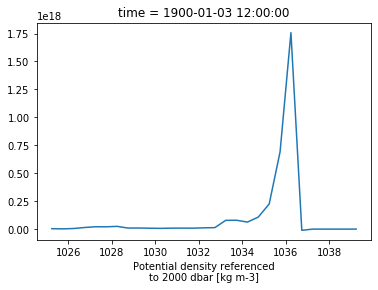

In [44]:
wmt = calc_watermasstransformation(tracer = l,
                                   tracer_tendency = ldot,
                                   tracer_contour_values = l_i_vals,
                                   prefactor = rho0,
                                   area = area,
                                   coordinate_transform_method='xhistogram',
                                   extensive_tendency=True)
wmt.isel(time=0).plot()

Calculate watermass transformation (due to salt tendency)

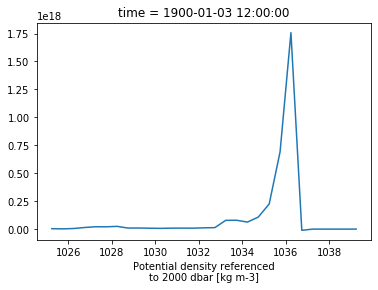

In [45]:
wmt = calc_watermasstransformation(tracer = l,
                                   tracer_tendency = ldot_salt,
                                   tracer_contour_values = l_i_vals,
                                   prefactor = rho0,
                                   area = area,
                                   coordinate_transform_method='xhistogram',
                                   extensive_tendency=True)
wmt.isel(time=0).plot()